In [1]:
from scipy.sparse import dia_matrix

import networkx as nx
from networkx import shortest_path_length as nx_path

import numpy as np
import random as rand
import itertools
import statistics as stats
import pandas as pd
from timeit import default_timer as timer

import matplotlib.pyplot as plt
from pprint import pprint

from sys import maxsize

np.set_printoptions(threshold=maxsize)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
""" all simulation and label functions return ([label-vector], runtime) """


def simulateInfection(G, src, model="SI", lamda=0.3, threshold=0.3):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    infected_nodes = {src}

    while True:
        temp_infected = infected_nodes.copy()

        for node in infected_nodes:
            for neighbour in G.neighbors(node):
                if rand.random() < lamda:
                    temp_infected.add(neighbour)

        infected_nodes = temp_infected

        if len(infected_nodes) > threshold * N:
            break

    y = np.full(N, -1)
    for infNode in infected_nodes:
        y[nodes.index(infNode)] = 1

    return y

<IPython.core.display.Javascript object>

In [3]:
def labelRankingScore(G, y, alpha=0.5):
    start = timer()
    N = G.number_of_nodes()

    W = nx.adjacency_matrix(G)
    diag_elem = W.sum(axis=1).A1 ** (-0.5)

    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())
    S = inv_sqrt_D @ W @ inv_sqrt_D

    f = np.copy(y)

    while True:
        f_ = alpha * S @ f + (1 - alpha) * y

        if np.linalg.norm(f - f_) < 0.001 * N:  # Convergence Criteria
            break

        f = f_

    tup = [(n, f[i]) for i, n in enumerate(G.nodes())]

    end = timer()
    return dict(tup), end - start

<IPython.core.display.Javascript object>

In [7]:
""" known_dicts = [ {infected: [nodes], safe: [nodes]} ] """


def simulatePartialInfection(
    G, src, model="SI", lamda=0.3, threshold=0.3, sampling=0.7, n_snaps=1
):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    infected = {src}

    while True:
        temp_infected = infected.copy()

        for node in infected:
            for neighbour in nx.all_neighbors(G, node):
                if rand.random() < lamda:
                    temp_infected.add(neighbour)

        infected = temp_infected

        if len(infected) > threshold * N:
            break

    snapshots = [rand.sample(nodes, int(sampling * N)) for _ in range(n_snaps)]
    known_dicts = [{"infected": [], "safe": []} for _ in range(n_snaps)]

    for i, snapshot in enumerate(snapshots):
        for node in snapshot:
            known_dicts[i]["infected" if node in infected else "safe"].append(node)

    return known_dicts

<IPython.core.display.Javascript object>

In [57]:
def resetF(F, known_dict, nodes):
    for node in known_dict["safe"]:
        indx = nodes.index(node)
        F[indx][0] = 1
        F[indx][1] = 0

    for node in known_dict["infected"]:
        indx = nodes.index(node)
        F[indx][0] = 0
        F[indx][1] = 1


def GFHF(G, known_dict):
    start = timer()
    nodes = list(G.nodes())

    N = G.number_of_nodes()
    W = nx.adjacency_matrix(G)

    diag_elem = 1 / W.sum(axis=1).A1
    inv_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    P = inv_D @ W
    F = np.zeros((N, 2))

    resetF(F, known_dict, nodes)

    while True:
        F_ = P @ F
        curr_diff = sum(sum(abs(F - F_)))

        resetF(F, known_dict, nodes)

        if curr_diff < 0.0001 * N:  # Convergence Criteria
            break

        F = F_

    O = np.array([1 if f[1] > f[0] else -1 for f in F])

    end = timer()
    return O, end - start


def TSSI_GFHF(G, labelled, src):
    O, partial_time = GFHF(G, labelled)
    dict_scores, complete_time = labelRankingScore(G, O)

    pred_src = max(dict_scores, key=dict_scores.get)
    dist_err = nx_path(G, src, pred_src)

    return dist_err, partial_time + complete_time


def LGC(G, known_dict, alpha):
    start = timer()

    nodes = list(G.nodes())

    N = G.number_of_nodes()
    W = nx.adjacency_matrix(G)

    diag_elem = W.sum(axis=1).A1 ** (-0.5)
    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    S = inv_sqrt_D @ W @ inv_sqrt_D
    F = np.zeros((N, 2))

    resetF(F, known_dict, nodes)
    Y = np.copy(F)

    while True:
        F_ = alpha * S @ F + (1 - alpha) * Y

        if sum(sum(abs(F - F_))) < 0.0001 * N:  # Convergence Criterion
            break

        F = F_

    O = np.array([1 if f[1] > f[0] else -1 for f in F])

    end = timer()
    return O, end - start


def TSSI_LGC(G, labelled, src, alpha=0.5):
    O, partial_time = LGC(G, labelled, alpha=alpha)
    dict_scores, complete_time = labelRankingScore(G, O)

    pred_src = max(dict_scores, key=dict_scores.get)
    dist_err = nx_path(G, src, pred_src)

    return dist_err, partial_time + complete_time

<IPython.core.display.Javascript object>

In [68]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

with open("football.csv", "r") as data:
    next(data, None)
    G_football = nx.parse_edgelist(
        data, delimiter=",", create_using=nx.Graph, nodetype=int
    )

with open("facebook.csv", "r") as data:
    next(data, None)
    G_facebook = nx.parse_edgelist(
        data, delimiter=",", create_using=nx.Graph, nodetype=int
    )

d_url = "http://www-personal.umich.edu/~mejn/netdata/dolphins.zip"
with urlopen(d_url) as sock, ZipFile(BytesIO(sock.read())) as zf:
    gml = zf.read("dolphins.gml").decode().split("\n")[1:]
    G_dolphin = nx.parse_gml(gml)

<IPython.core.display.Javascript object>

In [105]:
# Counter -> dict {item: freq}
from collections import Counter, defaultdict


def gen_data(algo, dataset, n_snaps=10):

    df_dist_err = defaultdict(list)
    df_time = defaultdict(list)
    err_freq = []

    for G_name, G in dataset.items():
        src = rand.choice(list(G.nodes()))
        N = G.number_of_nodes()

        known_dicts = simulatePartialInfection(
            G, src, threshold=0.3, sampling=0.2, n_snaps=n_snaps
        )

        score_time = [
            [alg(G, label, src) for label in known_dicts] for alg in algo.values()
        ]

        """
        alg_data = [alg1 [], alg2 [] ...]
        alg1 [] -> [(dist_err), (snapshot_time)]
        snapshot_score_dict = {node: score}
        """

        alg_data = [list(zip(*res)) for res in score_time]
        
        dict_freq = defaultdict(list)
        
        freq_hops = [Counter(err) for err, _ in alg_data]
        avg_dist_err = [stats.mean(err) for err, _ in alg_data]
        avg_time = [stats.mean(time) for _, time in alg_data]

        for alg_name, de, time, freq in zip(algo.keys(), avg_dist_err, avg_time, freq_hops):
            df_dist_err[alg_name].append(de)
            df_time[alg_name].append(time)
            dict_freq[alg_name] = [freq[i] if i in freq else 0 for i in range(4)]
        
        df = pd.DataFrame(dict_freq, columns=algo.keys(), index=list(range(4)))
        err_freq.append(df)
    
    df_de = pd.DataFrame(df_dist_err, columns=algo.keys(), index=dataset.keys())
    df_time = pd.DataFrame(df_time, columns=algo.keys(), index=dataset.keys())
                        
    return df_de, df_time, err_freq


de, time, err_freq = gen_data(
    {"GFHF": TSSI_GFHF, "LGC": TSSI_LGC},
    {
        "Karate": nx.karate_club_graph(),
        "Football": G_football,
        'Facebook': G_facebook,
        'Dolphin': G_dolphin
    },
)


<IPython.core.display.Javascript object>

<AxesSubplot:>

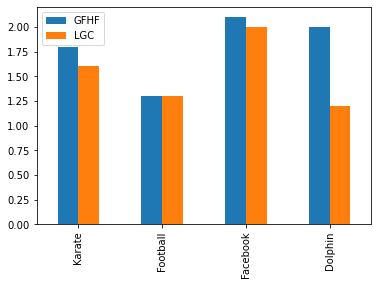

<IPython.core.display.Javascript object>

In [70]:
de.plot.bar()

<AxesSubplot:>

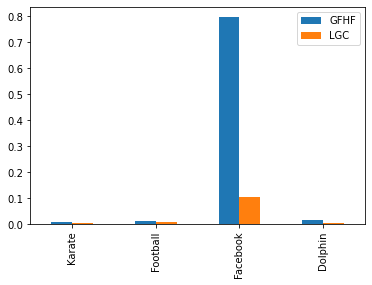

<IPython.core.display.Javascript object>

In [71]:
time.plot.bar()

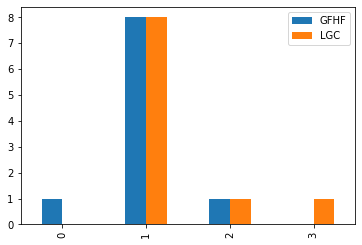

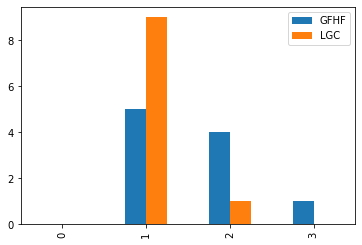

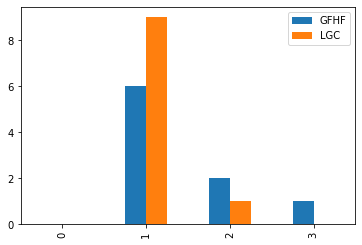

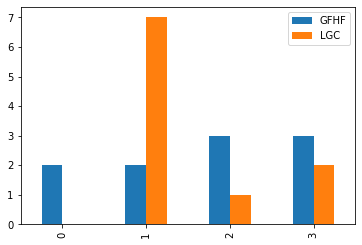

<IPython.core.display.Javascript object>

In [107]:
for df in err_freq:
    df.plot.bar()